In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
dataset_dir = '/content/drive/MyDrive/sorted_waste_dataset'


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Sklearn
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.stats import zscore

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input, Lambda
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


In [ ]:
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validate_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'validate'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())


Found 7324 images belonging to 6 classes.
Found 2182 images belonging to 6 classes.
Found 1210 images belonging to 6 classes.


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix Heatmap")
    plt.show()

    return accuracy, precision, f1


In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Use MobileNetV2 for faster feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

def extract_features(generator):
    """
    Extracts CNN features for ML models from a Keras ImageDataGenerator
    """
    steps = generator.samples // generator.batch_size + 1
    features = base_model.predict(generator, steps=steps)
    features_flat = features.reshape(features.shape[0], -1)
    labels = generator.classes[:features_flat.shape[0]]  # ensure alignment
    return features_flat, labels

# Extract features for all datasets
X_train, y_train = extract_features(train_generator)
X_validate, y_validate = extract_features(validate_generator)
X_test, y_test = extract_features(test_generator)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")



NameError: name 'train_generator' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import joblib

# Define ML models
models_ml = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results_ml = {}

for name, model in models_ml.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate
    from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    results_ml[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.2f}%")
    print(f"{name} Precision (Macro): {precision:.4f}")
    print(f"{name} F1-Score (Macro): {f1:.4f}")

    # Confusion matrix & heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{name} Confusion Matrix Heatmap")
    plt.show()

    # Save model
    joblib.dump(model, f"{name.replace(' ','_')}.pkl")
    print(f"{name} saved as {name.replace(' ','_')}.pkl")



Training Logistic Regression...


NameError: name 'X_train' is not defined

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Clear previous sessions
tf.keras.backend.clear_session()

# Dataset paths
dataset_dir = "/content/drive/MyDrive/sorted_waste_dataset"  # Update if local
img_height, img_width = 224, 224
batch_size = 16  # smaller batch for RAM efficiency# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

validate_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "validate"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

# Use lightweight MobileNetV2 for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

# Function to extract features in batches
def extract_and_save_features(generator, save_path, model):
    steps = generator.samples // generator.batch_size + 1
    features_list = []
    labels_list = []

    for i in range(steps):
        x_batch, y_batch = next(generator)
        feats = model.predict(x_batch)
        feats_flat = feats.reshape(feats.shape[0], -1)
        features_list.append(feats_flat)
        labels_list.append(np.argmax(y_batch, axis=1))

    X = np.vstack(features_list)
    y = np.hstack(labels_list)

    # Save to disk for later use
    np.save(f"{save_path}_X.npy", X)
    np.save(f"{save_path}_y.npy", y)

    return X, y

# Extract features for train, validate, test sets
X_train, y_train = extract_and_save_features(train_generator, "train_features", base_model)
X_validate, y_validate = extract_and_save_features(validate_generator, "validate_features", base_model)
X_test, y_test = extract_and_save_features(test_generator, "test_features", base_model)

# Clear model to free RAM
tf.keras.backend.clear_session()

print("Step 4 completed: Features extracted and saved.")


Found 7374 images belonging to 6 classes.
Found 2182 images belonging to 6 classes.
Found 1210 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━


Training Logistic Regression...

--- Logistic Regression ---
Accuracy: 83.97%
Precision: 0.7581
F1-Score: 0.7913


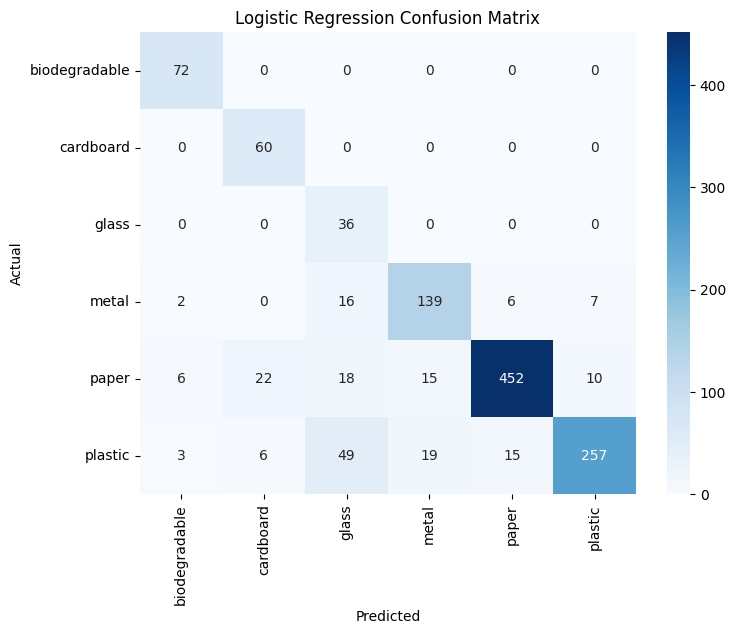

Logistic Regression saved successfully.

Training Random Forest...

--- Random Forest ---
Accuracy: 60.66%
Precision: 0.6506
F1-Score: 0.5924


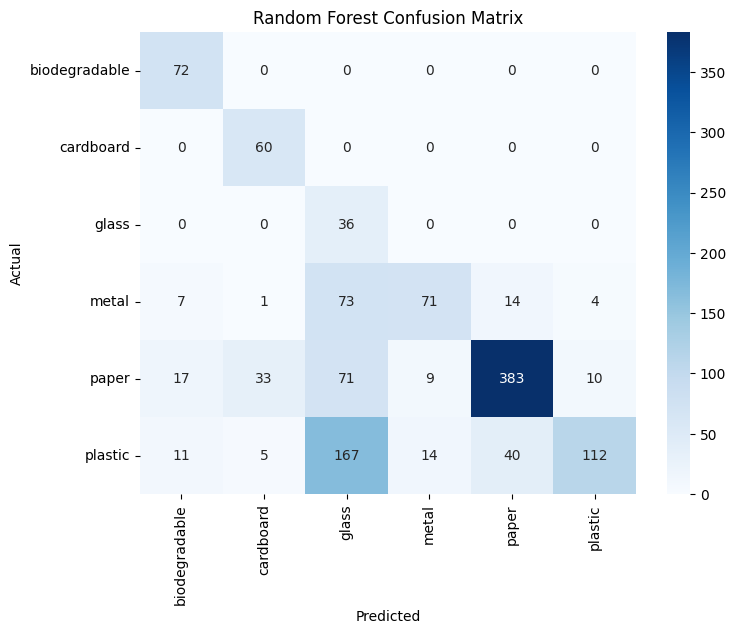

Random Forest saved successfully.

Training KNN...

--- KNN ---
Accuracy: 70.99%
Precision: 0.6917
F1-Score: 0.6564


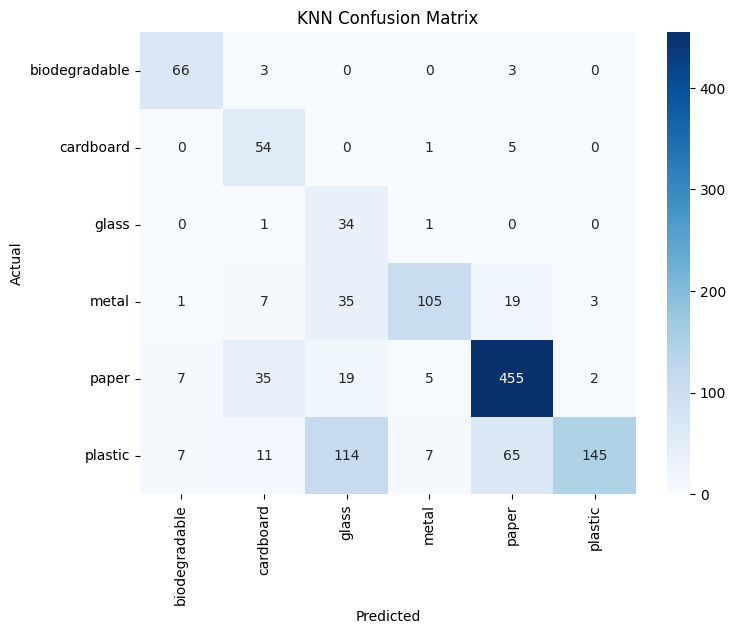

KNN saved successfully.

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:04:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)*100
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return accuracy, precision, f1

# Define 5 ML models
ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Train, evaluate, and save models
results = {}
for name, model in ml_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc, prec, f1 = evaluate_model(y_test, y_pred, name)
    results[name] = acc
    joblib.dump(model, f"{name.replace(' ','_')}.pkl")
    print(f"{name} saved successfully.")

print("Step 5 completed: All 5 ML models trained, evaluated, and saved.")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
import os # Import os for path operations
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Clear session
tf.keras.backend.clear_session()

# -------------------------------
# Define dataset parameters and generators
# -------------------------------
dataset_dir = "/content/drive/MyDrive/sorted_waste_dataset"
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

validate_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "validate"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(train_generator.class_indices.keys())

# -------------------------------
# Define number of classes manually
# -------------------------------
num_classes = 6   # biodegradable, paper, plastic, cardboard, glass, metal

# -------------------------------
# Evaluation Function (copied from rqDlo0M2_WO2) - MOVED TO TOP
# -------------------------------
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix Heatmap")
    plt.show()

    return accuracy, precision, f1

# -------------------------------
# Build CNN Model
# -------------------------------
def build_cnn(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])
    return model

# -------------------------------
# Compile Model
# -------------------------------
cnn_model = build_cnn(num_classes=num_classes)

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------------
# Train Model
# -------------------------------
cnn_model.fit(
    train_generator,
    validation_data=validate_generator,
    epochs=3
)

# -------------------------------
# Predictions
# -------------------------------
y_pred_cnn = np.argmax(
    cnn_model.predict(test_generator),
    axis=1
)

y_true_cnn = test_generator.classes

# -------------------------------
# Evaluation
# -------------------------------
evaluate_model(y_true_cnn, y_pred_cnn, "CNN From Scratch")

# -------------------------------
# Save Model
# -------------------------------
cnn_model.save("cnn_from_scratch.h5")

print("CNN From Scratch completed successfully.")

Found 7374 images belonging to 6 classes.
Found 2182 images belonging to 6 classes.
Found 1210 images belonging to 6 classes.
Epoch 1/3
  5/461 ━━━━━━━━━━━━━━━━━━━━ 16:36 2s/step - accuracy: 0.1910 - loss: 3.4007

KeyboardInterrupt: 